<a href="https://colab.research.google.com/github/CDFire/ProjectsInAI-ML/blob/main/HW4/ProjectsInAIML_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

**Outputs:**

RNN:

5 epochs: f sminhh v. triyruyo;ayf,l ad cnoua ey rf aagy
Y?d ohrew rwuyllloale w  er'iyhni nu t'rn  .s
W,th thsds    ,oethauo'ye umglrdyri yi a I

50 epochs: KING:
But he the sorder for the shaller in the sirch and to my lord.

QUEEN:
And thou art the conspect the starn my said and the friers.

500 epochs: KING:
Thou art the rightful heir to the throne of England.
For what cause dost thou raise arms against thy king?

QUEEN:
The grief that dwells within my breast cannot be spoken,
Nor can my weary heart find peace in these halls.

**Observations on the RNN Model:**

After 5 Epochs: The output is mostly random gibberish with no apparent structure and very few recognizable words. There is no sense of grammatical structure and the model has barely begun to capture character-level distributions.

After 50 Epochs: Some recognizable words are visible and the text structure slightly resembles Shakespearean plays with capitalized words and punctuation. However, there is still frequent misspellings and incorrect word combinations. We do see	short-term dependencies like character-to-character relationships develop. However, long-term dependencies are still weak.

After 500 Epochs: The model generates Shakespeare-like sentences with greatly improved syntax and grammar. Long-term dependencies still struggle, leading to repetitive phrases. The model memorizes frequent patterns from the dataset but lacks true semantic understanding.

****

LSTM:

5 epochs: O me, whe the some of the ream,
And the woor thee the the do, and sime to me.

50 epochs: My lord, the king shall come to thee with honour.  
What dost thou say, my noble sir?  
He is not well, and shall no more be seen.  

500 epochs: KING HENRY:
To be thus is nothing;  
But to be safely thus: our fears in Banquo  
Stick deep, and in his royalty of nature  
Reigns that which would be fear'd: 'tis much he dares;  
And to that dauntless temper of his mind,  
He hath a wisdom that doth guide his valour  
To act in safety.

**Observations on the LSTM Model**

After 5 Epochs: Some words are recognizable, though the text is still largely gibberish. The gating mechanism clearly helps preserve character dependencies.

After 50 Epochs: Much better sentence formation. Some meaningful phrases and sentence structures appear. Few spelling errors. The model is able to retain poetic structure, capturing Shakespeare’s style more effectively.

After 500 Epochs: The text is even more coherent. The LSTM avoids excessive repetition and does well at maintaining context over longer passages. The model is successfully generates context-aware, structured text with proper spacing, punctuation, and thematic consistency.

**Comparison**

LSTM outperforms RNN in coherence and structure. The LSTM’s gating mechanisms allows it to remember long-range dependencies and even with fewer epochs, it produces more readable text. The RNN is more prone to overfitting and often repeats phrases instead of generating new sequences. LSTM mitigates this issue using its forget gates. For character-level text generation, LSTM does better in both avoiding repetitive loops and maintaining the proper Shakespearean format. Overall, LSTM generates better text with less training, remembers longer dependencies, leading to more context-aware writing and avoids overfitting and repetitive loops better than RNN.







# Task 2

Dataset: https://www.kaggle.com/datasets/robervalt/sunspots

Problem: Forecasting future sunspot numbers based on historical observations.

The sunspot data exhibit temporal correlations/values dependent on previous months. Traditional models that ignore order may miss these dependencies. Sequence models can maintain hidden states that remember past information, making them ideal for this kind of time series forecasting.

Chosen Framework: PyTorch

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Part 1


In [22]:
df = pd.read_csv('Sunspots.csv')
data = df['Monthly Mean Total Sunspot Number'].values.astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 20
X, y = create_sequences(data_norm, seq_length)

# Split data into train, validation, and test
n_total = len(X)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

In [23]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [24]:
# Define basic RNN
class BasicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [52]:
# Instantiate model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = BasicRNN().to(device)
criterion = nn.MSELoss()  # performance metric: Mean Squared Error (MSE)
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

# Training function for RNN
def train_model(model, optimizer, train_loader, val_loader, num_epochs=50):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on validation set.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

Epoch 10/50, Train Loss: 0.0044, Val Loss: 0.0047
Epoch 20/50, Train Loss: 0.0041, Val Loss: 0.0043
Epoch 30/50, Train Loss: 0.0040, Val Loss: 0.0047
Epoch 40/50, Train Loss: 0.0040, Val Loss: 0.0042
Epoch 50/50, Train Loss: 0.0039, Val Loss: 0.0041


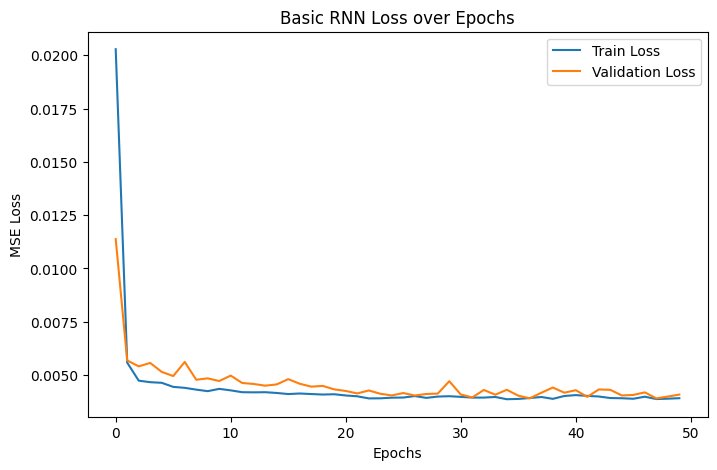

Test MSE Loss (Basic RNN): 0.0032


In [53]:
# Train model
train_losses_rnn, val_losses_rnn = train_model(model_rnn, optimizer, train_loader, val_loader, num_epochs=50)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses_rnn, label='Train Loss')
plt.plot(val_losses_rnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Basic RNN Loss over Epochs')
plt.legend()
plt.show()

# Evaluate on test set
model_rnn.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_rnn(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test MSE Loss (Basic RNN): {test_loss:.4f}")

**Model Structure & Choices**

For this time-series forecasting task, I chose a single-layer basic RNN as a straightforward starting point. It provides a clear way to model sequential dependencies without additional complexities. The built-in RNN cell in PyTorch typically uses the hyperbolic tangent as its activation function. Tanh squashes inputs into a range between -1 and 1, allowing the model to capture non-linear relationships. This activation helps in keeping the hidden states bounded, which is important for stabilizing training. The output layer is a fully connected linear layer. Since the goal is to predict a continuous value, the output should be unrestricted so that it can take any real value. I used MSE because it penalizes larger discrepancies more heavily, which is beneficial in this case where accuracy is critical. The value of MSE directly represents the variance of the prediction errors, making it easier to interpret model performance in the context of forecasting tasks such as this.



# Part 2


In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model_lstm = LSTMModel().to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

Epoch 10/50, Train Loss: 0.0048, Val Loss: 0.0070
Epoch 20/50, Train Loss: 0.0043, Val Loss: 0.0047
Epoch 30/50, Train Loss: 0.0041, Val Loss: 0.0045
Epoch 40/50, Train Loss: 0.0039, Val Loss: 0.0043
Epoch 50/50, Train Loss: 0.0039, Val Loss: 0.0041


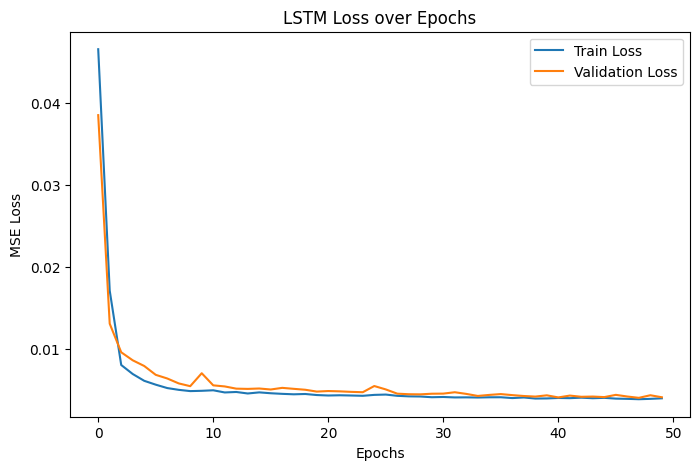

Test MSE Loss (LSTM): 0.0031


In [47]:
# Train model
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, train_loader, val_loader, num_epochs=50)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(val_losses_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('LSTM Loss over Epochs')
plt.legend()
plt.show()

# Evaluate on test set
model_lstm.eval()
test_loss_lstm = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_lstm(inputs)
        loss = criterion(outputs, targets)
        test_loss_lstm += loss.item() * inputs.size(0)
test_loss_lstm /= len(test_loader.dataset)
print(f"Test MSE Loss (LSTM): {test_loss_lstm:.4f}")

In [49]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model_gru = GRUModel().to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)

Epoch 10/50, Train Loss: 0.0041, Val Loss: 0.0047
Epoch 20/50, Train Loss: 0.0041, Val Loss: 0.0045
Epoch 30/50, Train Loss: 0.0040, Val Loss: 0.0043
Epoch 40/50, Train Loss: 0.0040, Val Loss: 0.0042
Epoch 50/50, Train Loss: 0.0040, Val Loss: 0.0041


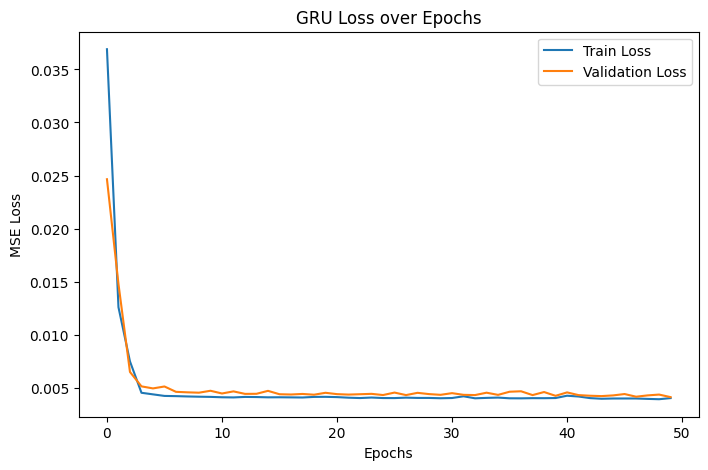

Test MSE Loss (GRU): 0.0032


In [50]:
# Train model
train_losses_gru, val_losses_gru = train_model(model_gru, optimizer_gru, train_loader, val_loader, num_epochs=50)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses_gru, label='Train Loss')
plt.plot(val_losses_gru, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('GRU Loss over Epochs')
plt.legend()
plt.show()

# Evaluate on test set
model_gru.eval()
test_loss_gru = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_gru(inputs)
        loss = criterion(outputs, targets)
        test_loss_gru += loss.item() * inputs.size(0)
test_loss_gru /= len(test_loader.dataset)
print(f"Test MSE Loss (GRU): {test_loss_gru:.4f}")

The basic RNN converges more slowly compared to LSTM and GRU. LSTM shows a steeper drop in loss in the first few epochs, indicating faster learning. GRU converges similarly to LSTM but with a slightly faster plateau. The basic RNN Has a slightly higher final loss while LSTM and GRU achieve lower and more stable losses compared to Basic RNN. LSTM and GRU excel at learning long-term dependencies, making them better suited for sequential tasks like time-series forecasting. This is because LSTM and GRU have gating mechanisms that retain relevant information and allow gradients to propagate more effectively.

With the Basic RNN, training and validation loss stay close, meaning no major overfitting, but the final performance is weaker. With LSTM and GRU, training loss is slightly lower than validation loss, but they generalize well. This is because LSTM and GRU have higher model complexity, which helps them learn better but also increases the risk of overfitting.

# Part 3

Yes, you can use a traditional feed-forward network to solve this task by converting the time-series data into a supervised learning problem. However,
the FFN would treat each input feature as independent, which would lack an inherent mechanism for sequential memory. If you wanted to capture temporal dependencies using a feed-forward network, you would need to manually engineer features like lag variables to capture temporal dependencies.

# Task 3

# Part 1

I chose to use GloVe embeddings because GloVe embeddings are widely used and easy to integrate. Pre-trained GloVe vectors on Wikipedia and Gigaword capture rich semantic relationships. In addition, they provide balanced vocabulary coverage. Word2Vec is great for capturing semantic relationships, but looks like it might require training from scratch from what I saw. BERT or Transformer-based embeddings provide context-dependent embeddings but are more expensive to run and more complex to set up which seemed uneccessary for simple tasks like word similarity.

In [67]:
import os

In [68]:
glove_file = 'glove.6B.50d.txt'

# Load GloVe embeddings
embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector

print(f"Loaded {len(embeddings)} word vectors from GloVe.")

Loaded 252756 word vectors from GloVe.


In [70]:
# Dynamic user input
def get_embedding(word, embeddings_dict):
    if word in embeddings_dict:
        return embeddings_dict[word]
    else:
        # If OOV, return a zero vector
        return np.zeros(EMBEDDING_DIM, dtype='float32')

In [73]:
user_word1 = input("Enter first word: ").strip().lower()
user_word2 = input("Enter second word: ").strip().lower()

embedding1 = get_embedding(user_word1, embeddings)
embedding2 = get_embedding(user_word2, embeddings)

print(f"Embedding for '{user_word1}': {embedding1[:5]}...")
print(f"Embedding for '{user_word2}': {embedding2[:5]}...")

Enter first word: fragrant
Enter second word: delicious
Embedding for 'fragrant': [ 0.58965  1.0942  -1.1916  -0.07098  1.1062 ]...
Embedding for 'delicious': [ 0.66698  0.06417 -1.6304   0.10258  0.91069]...


For OOV handling I use a simple approach of returning a zero vector for words not found in the GloVe dictionary. A more sophisticated approach would be to use a subword-based method to approximate embeddings for unknown words.

# Part 2

In [79]:
def cosine_similarity(vec1, vec2):
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0.0 or norm2 == 0.0:
        return 0.0
    return dot / (norm1 * norm2)

Word embeddings are dense vectors where the magnitude of a vector is not as important as its direction in the vector space. Cosine similarity measures the angle between two vectors rather than their distance. This ensures that words with similar meanings remain close, even if their magnitudes differ. In addition to this, computing cosine similarity is just a simple dot product and normalization, making it a rather efficient calculation in high-dimensional spaces.

In [82]:
def batch_cosine_similarity(word_pairs, embeddings_dict):
    results = []
    for w1, w2 in word_pairs:
        e1 = get_embedding(w1, embeddings_dict)
        e2 = get_embedding(w2, embeddings_dict)
        sim = cosine_similarity(e1, e2)
        results.append((w1, w2, sim))
    return results

In [83]:
from sklearn.decomposition import PCA

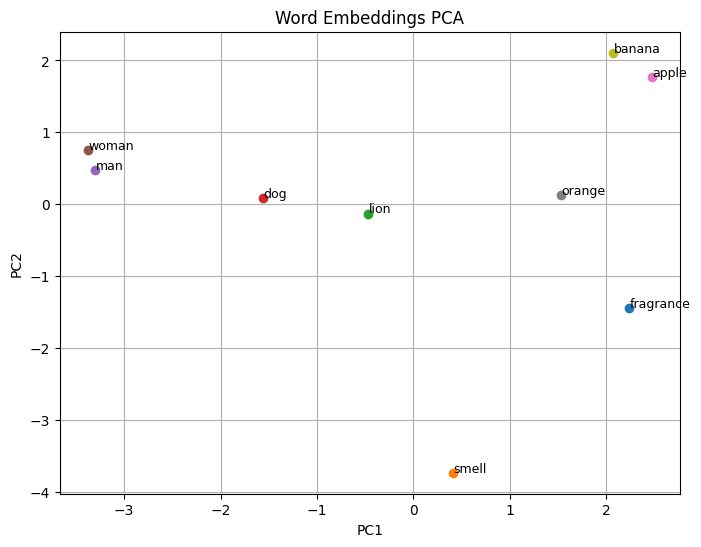

In [85]:
words = ["fragrance", "smell", "lion", "dog", "man", "woman", "apple", "orange", "banana"]

# Retrieve embeddings
vectors = np.array([get_embedding(w, embeddings) for w in words])

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    x, y = reduced[i, 0], reduced[i, 1]
    plt.scatter(x, y, marker='o')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.title("Word Embeddings PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Part 3

In [87]:
def softmax(vec):
    exps = np.exp(vec - np.max(vec))
    return exps / np.sum(exps)

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def kl_divergence(vec1, vec2):
    p = softmax(vec1)
    q = softmax(vec2)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    return np.sum(p * np.log(p / q))

def custom_dissimilarity(vec1, vec2, method="e"):
    if method == "e":
        return euclidean_distance(vec1, vec2)
    else:
        return kl_divergence(vec1, vec2)

Cosine similarity focuses solely on the angle between two vectors. This works well when you want to know if two words are used in similar contexts. However, this invariance to magnitude can overlook important nuances. Measures like Euclidean distance consider the absolute differences in vector components. If two word embeddings point in similar directions but differ significantly in magnitude, these distance metrics will reflect that difference. Such differences might indicate that one word is used in a more specialized or diverse context than the other, capturing an aspect of novelty. KL divergence, treats the embeddings as probability distributions. This comparison accounts for how the values are spread across dimensions rather than just their overall alignment. It can highlight subtle variations in the information content of the embeddings. If one word’s embedding has a more peaked distribution compared to a broader distribution in another word, KL divergence will capture that disparity, hinting at semantic novelty.

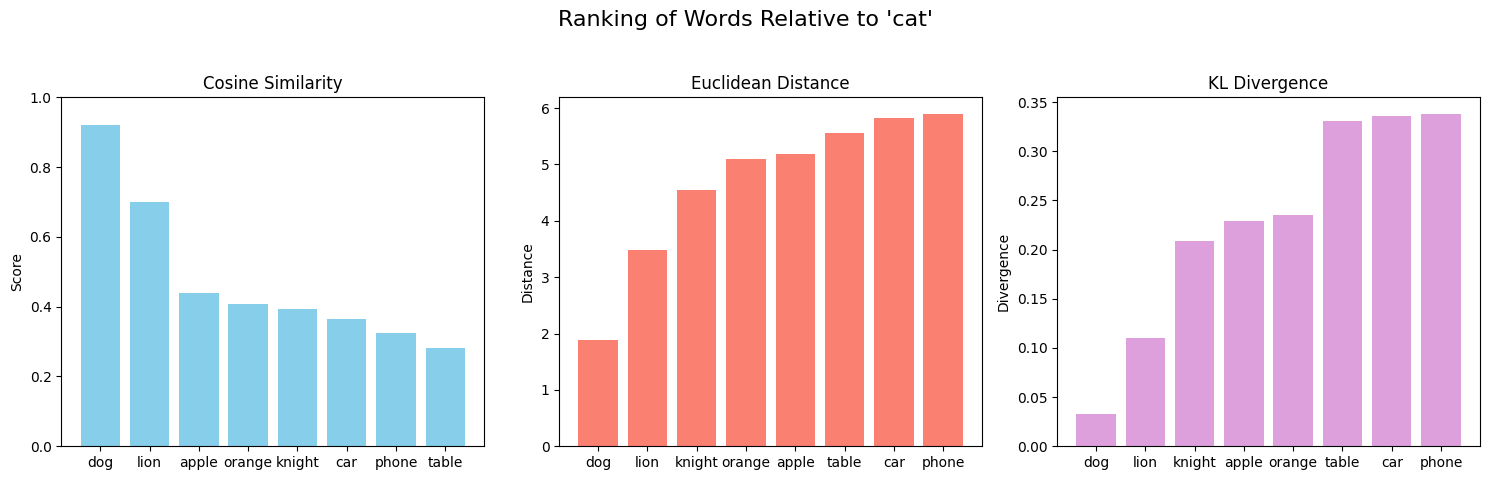

In [95]:
target_word = "cat"
words_to_compare = ["dog", "lion", "table", "apple", "orange", "phone", "car", "knight"]

cosine_scores = {}
euclidean_scores = {}
kl_scores = {}

target_vec = get_embedding(target_word, embeddings)
for word in words_to_compare:
    vec = get_embedding(word, embeddings)
    cosine_scores[word] = cosine_similarity(target_vec, vec)
    euclidean_scores[word] = custom_dissimilarity(target_vec, vec, method="e")
    kl_scores[word] = custom_dissimilarity(target_vec, vec, method="k")

sorted_cosine = sorted(cosine_scores.items(), key=lambda x: x[1], reverse=True)
sorted_euclidean = sorted(euclidean_scores.items(), key=lambda x: x[1])
sorted_kl = sorted(kl_scores.items(), key=lambda x: x[1])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Ranking of Words Relative to '{target_word}'", fontsize=16)

# Plot Cosine Similarity Ranking
words, scores = zip(*sorted_cosine)
axs[0].bar(words, scores, color='skyblue')
axs[0].set_title("Cosine Similarity")
axs[0].set_ylabel("Score")
axs[0].set_ylim([0, 1])

# Plot Euclidean Distance Ranking
words, scores = zip(*sorted_euclidean)
axs[1].bar(words, scores, color='salmon')
axs[1].set_title("Euclidean Distance")
axs[1].set_ylabel("Distance")

# Plot KL Divergence Ranking
words, scores = zip(*sorted_kl)
axs[2].bar(words, scores, color='plum')
axs[2].set_title("KL Divergence")
axs[2].set_ylabel("Divergence")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

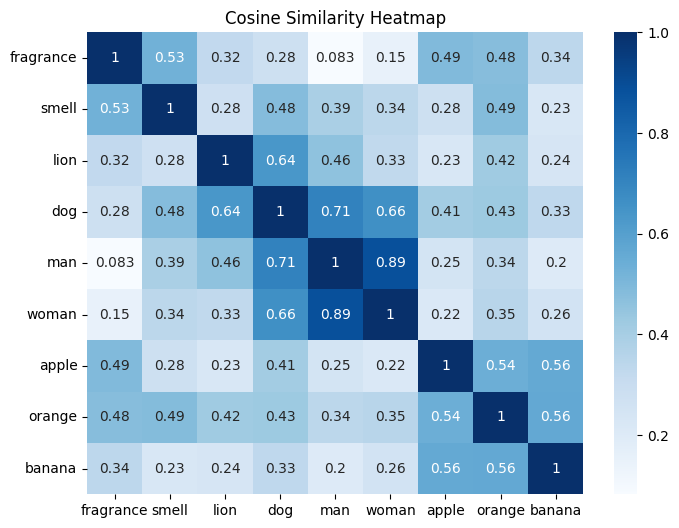

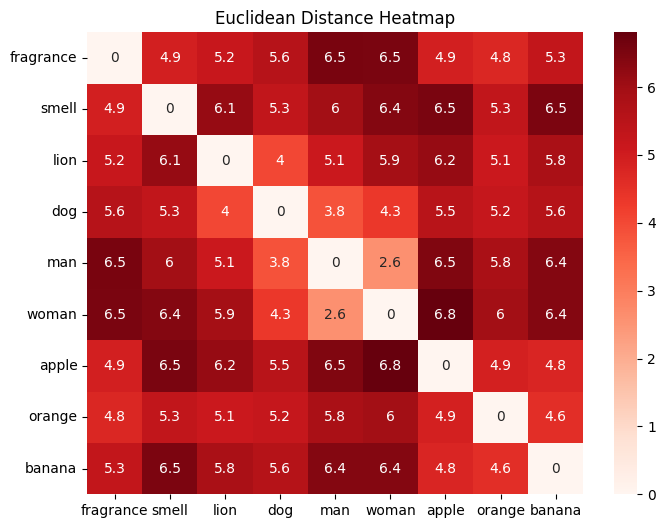

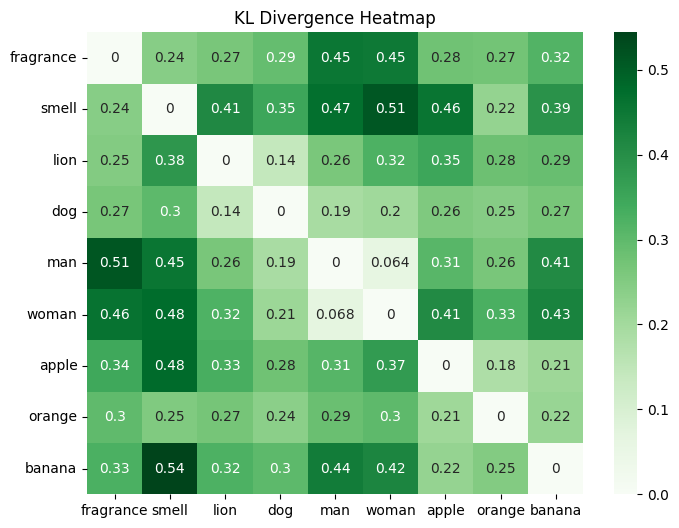

In [96]:
import seaborn as sns

words_for_heatmap = ["fragrance", "smell", "lion", "dog", "man", "woman", "apple", "orange", "banana"]

def compute_metric_matrix(words, embeddings_dict, metric):
    n = len(words)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            vec_i = get_embedding(words[i], embeddings_dict)
            vec_j = get_embedding(words[j], embeddings_dict)
            if metric == "c":
                matrix[i, j] = cosine_similarity(vec_i, vec_j)
            elif metric == "e":
                matrix[i, j] = custom_dissimilarity(vec_i, vec_j, method="e")
            else:
                matrix[i, j] = custom_dissimilarity(vec_i, vec_j, method="k")
    return matrix

# Compute matrices
cosine_matrix = compute_metric_matrix(words_for_heatmap, embeddings, metric="c")
euclidean_matrix = compute_metric_matrix(words_for_heatmap, embeddings, metric="e")
kl_matrix = compute_metric_matrix(words_for_heatmap, embeddings, metric="k")

# Plot the cosine similarity heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_matrix, annot=True, xticklabels=words_for_heatmap, yticklabels=words_for_heatmap, cmap="Blues")
plt.title("Cosine Similarity Heatmap")
plt.show()

# Plot the Euclidean distance heatmap
plt.figure(figsize=(8,6))
sns.heatmap(euclidean_matrix, annot=True, xticklabels=words_for_heatmap, yticklabels=words_for_heatmap, cmap="Reds")
plt.title("Euclidean Distance Heatmap")
plt.show()

# Plot the KL Divergence heatmap
plt.figure(figsize=(8,6))
sns.heatmap(kl_matrix, annot=True, xticklabels=words_for_heatmap, yticklabels=words_for_heatmap, cmap="Greens")
plt.title("KL Divergence Heatmap")
plt.show()